<a href="https://colab.research.google.com/github/saurabhsingh1411/Deep_Learning_Projects/blob/main/SEQUENCE/Neural%20Machine%20Translation/Neural_Machine_translation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import string 
import re 
from numpy import array ,argmax ,random,take 
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense,LSTM,Embedding,RepeatVector
from keras.preprocessing.text import Tokenizer
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from keras import optimizers
import matplotlib.pyplot as plt
%matplotlib inline 
pd.set_option('display.max_colwidth',200)


# Reading the files 

In [2]:
#function to read raw text files 

def read_text(filename):

  #open the file 
  file = open(filename, mode='rt', encoding='utf-8')

  #read all the text 
  text=file.read()
  file.close()

  return text 

In [3]:
# split a text into sentences

def to_lines(text):
  sents=text.strip().split('\n')
  sents=[i.split('\t') for i in sents]

  return sents


In [4]:
data=read_text('deu.txt')
deu_eng = to_lines(data)
deu_eng = array(deu_eng)

In [5]:
deu_eng

array([['Go.', 'Geh.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #8597805 (Roujin)'],
       ['Hi.', 'Hallo!',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #380701 (cburgmer)'],
       ['Hi.', 'Grüß Gott!',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #659813 (Esperantostern)'],
       ...,
       ['May I sit here?', 'Kann ich hier sitzen?',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #61514 (CK) & #804487 (Esperantostern)'],
       ['May I use that?', 'Darf ich das benutzen?',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #4642215 (CK) & #6645654 (Felixjp)'],
       ['May I use this?', 'Darf ich das verwenden?',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #549']],
      dtype='<U101')

The actual data contains over 150,000 sentence-pairs. However, we will use only the first 50,000 sentence pairs to reduce the training time of the model

In [6]:
deu_eng=deu_eng[:50000,:]

deu_eng

array([['Go.', 'Geh.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #8597805 (Roujin)'],
       ['Hi.', 'Hallo!',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #380701 (cburgmer)'],
       ['Hi.', 'Grüß Gott!',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #659813 (Esperantostern)'],
       ...,
       ['May I sit here?', 'Kann ich hier sitzen?',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #61514 (CK) & #804487 (Esperantostern)'],
       ['May I use that?', 'Darf ich das benutzen?',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #4642215 (CK) & #6645654 (Felixjp)'],
       ['May I use this?', 'Darf ich das verwenden?',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #549']],
      dtype='<U101')

In [7]:
deu_eng[0][:2]

array(['Go.', 'Geh.'], dtype='<U101')

In [8]:
deu_eng_final=[]
for i in range(len(deu_eng)):
  deu_eng_final.append(deu_eng[i][:2])


In [9]:
deu_eng=array(deu_eng_final)

In [10]:
deu_eng

array([['Go.', 'Geh.'],
       ['Hi.', 'Hallo!'],
       ['Hi.', 'Grüß Gott!'],
       ...,
       ['May I sit here?', 'Kann ich hier sitzen?'],
       ['May I use that?', 'Darf ich das benutzen?'],
       ['May I use this?', 'Darf ich das verwenden?']], dtype='<U101')

In [11]:
# Remove punctuation
deu_eng[:,0] = [s.translate(str.maketrans('', '', string.punctuation)) for s in deu_eng[:,0]]
deu_eng[:,1] = [s.translate(str.maketrans('', '', string.punctuation)) for s in deu_eng[:,1]]

deu_eng

array([['Go', 'Geh'],
       ['Hi', 'Hallo'],
       ['Hi', 'Grüß Gott'],
       ...,
       ['May I sit here', 'Kann ich hier sitzen'],
       ['May I use that', 'Darf ich das benutzen'],
       ['May I use this', 'Darf ich das verwenden']], dtype='<U101')

In [12]:
# convert text to lowercase
for i in range(len(deu_eng)):
    deu_eng[i,0] = deu_eng[i,0].lower()
    deu_eng[i,1] = deu_eng[i,1].lower()

deu_eng

array([['go', 'geh'],
       ['hi', 'hallo'],
       ['hi', 'grüß gott'],
       ...,
       ['may i sit here', 'kann ich hier sitzen'],
       ['may i use that', 'darf ich das benutzen'],
       ['may i use this', 'darf ich das verwenden']], dtype='<U101')

**Text to sequence conversion **

A Seq2Seq model requires that we convert both the input and the output sentences into integer sequences of fixed length.

But before we do that, let’s visualise the length of the sentences. We will capture the lengths of all the sentences in two separate lists for English and German, respectively.

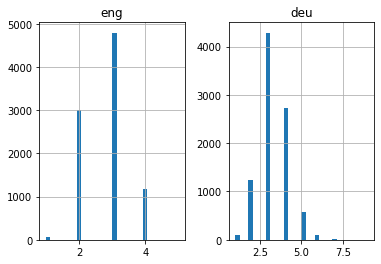

In [13]:
#empty_list 
eng_l=[]
deu_l=[]

#populate the list with sentence length 
for i in deu_eng[:,0]:
  eng_l.append(len(i.split()))

for i in deu_eng[:,1]:
  deu_l.append(len(i.split()))

length_df=pd.DataFrame({'eng':eng_l,'deu':deu_l})

length_df.hist(bins=30)

plt.show()


In [14]:
length_df.head()

,eng,deu
0,1,1
1,1,1
2,1,2
3,1,1
4,1,1


Note that we will prepare tokenizers for both the German and English sentences:

In [15]:
def tokenization(lines):
  tokenizer=Tokenizer()
  tokenizer.fit_on_texts(lines)

  return tokenizer

In [16]:
#prepare english tokenizer 
eng_tokenizer=tokenization(deu_eng[:,0])

eng_vocab_size=len(eng_tokenizer.word_index)+1

eng_length=8

print('English vocab size',eng_vocab_size)

English vocab size 2086


In [17]:
#prepare deuth tokenizer 
deu_tokenizer=tokenization(deu_eng[:,1])

deu_vocab_size=len(deu_tokenizer.word_index)+1

deu_length=8

print('deuth vocab size',deu_vocab_size)

deuth vocab size 3416


In [18]:
eng_tokenizer

In [19]:
def encode_sequences(tokenizer,length,lines):
  seq=tokenizer.texts_to_sequences(lines)
  seq=pad_sequences(seq,maxlen=length,padding='post')

  return seq 

Model Building

In [20]:
from sklearn.model_selection import train_test_split

# split data into train and test set
train, test = train_test_split(deu_eng, test_size=0.2, random_state = 12)

In [21]:
test

array([['she was naive', 'sie war leichtgläubig'],
       ['he has no fear', 'er fürchtet sich nicht'],
       ['drop the gun', 'lass die waffe fallen'],
       ...,
       ['tom is stingy', 'tom ist geizig'],
       ['who found tom', 'wer hat tom gefunden'],
       ['write me', 'schreibt mir']], dtype='<U101')

In [22]:
#prepare training and testing data

# prepare training data
trainX = encode_sequences(deu_tokenizer, deu_length, train[:, 1])
trainY = encode_sequences(eng_tokenizer, eng_length, train[:, 0])

# prepare validation data
testX = encode_sequences(deu_tokenizer, deu_length, test[:, 1])
testY = encode_sequences(eng_tokenizer, eng_length, test[:, 0])

In [23]:
print(trainX.shape,trainY.shape,testX.shape,testY.shape)

(7232, 8) (7232, 8) (1808, 8) (1808, 8)


In [24]:
trainX

array([[   2,  514,  100, ...,    0,    0,    0],
       [ 963,   41,    0, ...,    0,    0,    0],
       [ 217,   67,   15, ...,    0,    0,    0],
       ...,
       [  12, 3027,    0, ...,    0,    0,    0],
       [   7,    1,  825, ...,    0,    0,    0],
       [   1,  721,    6, ...,    0,    0,    0]], dtype=int32)

Model Architecture 

In [27]:
def define_model(in_vocab,out_vocab, in_timesteps,out_timesteps,units):
      model = Sequential()
      model.add(Embedding(in_vocab, units, input_length=in_timesteps, mask_zero=True))
      model.add(LSTM(units))
      model.add(RepeatVector(out_timesteps))
      model.add(LSTM(units, return_sequences=True))
      model.add(Dense(out_vocab, activation='softmax'))
      return model

In [28]:
#model.compilation 
model=define_model(deu_vocab_size,eng_vocab_size,deu_length,eng_length,512)

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 8, 512)            1748992   
_________________________________________________________________
lstm (LSTM)                  (None, 512)               2099200   
_________________________________________________________________
repeat_vector (RepeatVector) (None, 8, 512)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 8, 512)            2099200   
_________________________________________________________________
dense (Dense)                (None, 8, 2086)           1070118   
Total params: 7,017,510
Trainable params: 7,017,510
Non-trainable params: 0
_________________________________________________________________


In [29]:
print(deu_vocab_size,eng_vocab_size,deu_length,eng_length)

3416 2086 8 8


In [30]:
rms=optimizers.RMSprop(learning_rate=0.001)

model.compile(optimizer=rms,loss='sparse_categorical_crossentropy')

In [31]:
filename = 'model.h1.24_jan_19'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
# train model
history = model.fit(trainX, trainY.reshape(trainY.shape[0], trainY.shape[1], 1),
                    epochs=30, batch_size=512, validation_split = 0.2,callbacks=[checkpoint], 
                    verbose=1)

Epoch 1/30
12/12 [==============================] - 37s 182ms/step - loss: 5.3217 - val_loss: 2.5929

Epoch 00001: val_loss improved from inf to 2.59290, saving model to model.h1.24_jan_19


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


Epoch 2/30
12/12 [==============================] - 1s 55ms/step - loss: 2.4256 - val_loss: 2.5377

Epoch 00002: val_loss improved from 2.59290 to 2.53773, saving model to model.h1.24_jan_19


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


Epoch 3/30
12/12 [==============================] - 1s 58ms/step - loss: 2.2392 - val_loss: 2.2702

Epoch 00003: val_loss improved from 2.53773 to 2.27017, saving model to model.h1.24_jan_19


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


Epoch 4/30
12/12 [==============================] - 1s 56ms/step - loss: 2.0706 - val_loss: 2.1084

Epoch 00004: val_loss improved from 2.27017 to 2.10840, saving model to model.h1.24_jan_19


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


Epoch 5/30
12/12 [==============================] - 1s 58ms/step - loss: 1.9889 - val_loss: 2.1003

Epoch 00005: val_loss improved from 2.10840 to 2.10031, saving model to model.h1.24_jan_19


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


Epoch 6/30
12/12 [==============================] - 1s 55ms/step - loss: 1.9492 - val_loss: 2.0835

Epoch 00006: val_loss improved from 2.10031 to 2.08354, saving model to model.h1.24_jan_19


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


Epoch 7/30
12/12 [==============================] - 1s 55ms/step - loss: 1.9277 - val_loss: 2.0348

Epoch 00007: val_loss improved from 2.08354 to 2.03480, saving model to model.h1.24_jan_19


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


Epoch 8/30
12/12 [==============================] - 1s 54ms/step - loss: 1.8916 - val_loss: 2.0185

Epoch 00008: val_loss improved from 2.03480 to 2.01852, saving model to model.h1.24_jan_19


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


Epoch 9/30
12/12 [==============================] - 1s 54ms/step - loss: 1.8578 - val_loss: 1.9946

Epoch 00009: val_loss improved from 2.01852 to 1.99459, saving model to model.h1.24_jan_19


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


Epoch 10/30
12/12 [==============================] - 1s 56ms/step - loss: 1.8048 - val_loss: 1.9592

Epoch 00010: val_loss improved from 1.99459 to 1.95915, saving model to model.h1.24_jan_19


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


Epoch 11/30
12/12 [==============================] - 1s 54ms/step - loss: 1.7692 - val_loss: 1.9618

Epoch 00011: val_loss did not improve from 1.95915
Epoch 12/30
12/12 [==============================] - 1s 48ms/step - loss: 1.7174 - val_loss: 1.8897

Epoch 00012: val_loss improved from 1.95915 to 1.88973, saving model to model.h1.24_jan_19


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


Epoch 13/30
12/12 [==============================] - 1s 56ms/step - loss: 1.6752 - val_loss: 1.8838

Epoch 00013: val_loss improved from 1.88973 to 1.88378, saving model to model.h1.24_jan_19


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


Epoch 14/30
12/12 [==============================] - 1s 57ms/step - loss: 1.6153 - val_loss: 1.8768

Epoch 00014: val_loss improved from 1.88378 to 1.87683, saving model to model.h1.24_jan_19


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


Epoch 15/30
12/12 [==============================] - 1s 55ms/step - loss: 1.5772 - val_loss: 1.8462

Epoch 00015: val_loss improved from 1.87683 to 1.84620, saving model to model.h1.24_jan_19


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


Epoch 16/30
12/12 [==============================] - 1s 55ms/step - loss: 1.5177 - val_loss: 1.8482

Epoch 00016: val_loss did not improve from 1.84620
Epoch 17/30
12/12 [==============================] - 1s 48ms/step - loss: 1.5129 - val_loss: 1.8070

Epoch 00017: val_loss improved from 1.84620 to 1.80697, saving model to model.h1.24_jan_19


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


Epoch 18/30
12/12 [==============================] - 1s 55ms/step - loss: 1.4508 - val_loss: 1.7849

Epoch 00018: val_loss improved from 1.80697 to 1.78492, saving model to model.h1.24_jan_19


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


Epoch 19/30
12/12 [==============================] - 1s 57ms/step - loss: 1.4048 - val_loss: 1.7815

Epoch 00019: val_loss improved from 1.78492 to 1.78146, saving model to model.h1.24_jan_19


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


Epoch 20/30
12/12 [==============================] - 1s 58ms/step - loss: 1.3707 - val_loss: 1.7569

Epoch 00020: val_loss improved from 1.78146 to 1.75691, saving model to model.h1.24_jan_19


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


Epoch 21/30
12/12 [==============================] - 1s 57ms/step - loss: 1.3266 - val_loss: 1.7866

Epoch 00021: val_loss did not improve from 1.75691
Epoch 22/30
12/12 [==============================] - 1s 49ms/step - loss: 1.2863 - val_loss: 1.7680

Epoch 00022: val_loss did not improve from 1.75691
Epoch 23/30
12/12 [==============================] - 1s 49ms/step - loss: 1.2697 - val_loss: 1.7385

Epoch 00023: val_loss improved from 1.75691 to 1.73847, saving model to model.h1.24_jan_19


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


Epoch 24/30
12/12 [==============================] - 1s 55ms/step - loss: 1.2221 - val_loss: 1.6926

Epoch 00024: val_loss improved from 1.73847 to 1.69258, saving model to model.h1.24_jan_19


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


Epoch 25/30
12/12 [==============================] - 1s 57ms/step - loss: 1.1707 - val_loss: 1.7718

Epoch 00025: val_loss did not improve from 1.69258
Epoch 26/30
12/12 [==============================] - 1s 50ms/step - loss: 1.1684 - val_loss: 1.6987

Epoch 00026: val_loss did not improve from 1.69258
Epoch 27/30
12/12 [==============================] - 1s 48ms/step - loss: 1.1176 - val_loss: 1.6899

Epoch 00027: val_loss improved from 1.69258 to 1.68995, saving model to model.h1.24_jan_19


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


Epoch 28/30
12/12 [==============================] - 1s 57ms/step - loss: 1.0839 - val_loss: 1.7054

Epoch 00028: val_loss did not improve from 1.68995
Epoch 29/30
12/12 [==============================] - 1s 49ms/step - loss: 1.0606 - val_loss: 1.6444

Epoch 00029: val_loss improved from 1.68995 to 1.64445, saving model to model.h1.24_jan_19


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


Epoch 30/30
12/12 [==============================] - 1s 54ms/step - loss: 1.0319 - val_loss: 1.6411

Epoch 00030: val_loss improved from 1.64445 to 1.64108, saving model to model.h1.24_jan_19


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


INFO:tensorflow:Assets written to: model.h1.24_jan_19/assets


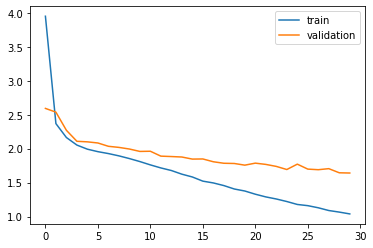

In [32]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','validation'])
plt.show()


In [38]:
model = load_model('model.h1.24_jan_19')
preds = model.predict_classes(testX.reshape((testX.shape[0],testX.shape[1])))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [39]:
def get_word(n, tokenizer):
      for word, index in tokenizer.word_index.items():
          if index == n:
              return word
      return None

In [35]:
preds_text = []
for i in preds:
       temp = []
       for j in range(len(i)):
            t = get_word(i[j], eng_tokenizer)
            if j > 0:
                if (t == get_word(i[j-1], eng_tokenizer)) or (t == None):
                     temp.append('')
                else:
                     temp.append(t)
            else:
                   if(t == None):
                          temp.append('')
                   else:
                          temp.append(t) 

       preds_text.append(' '.join(temp))

In [40]:
pred_df = pd.DataFrame({'actual' : test[:,0], 'predicted' : preds_text})

In [41]:
# print 15 rows randomly
pred_df.sample(15)

,actual,predicted
1042,were close,were won
1796,go home,go back
477,i fainted,i said to
1278,ignore them,come them
1665,i need a smoke,i want a
736,go away,go away
1723,whos paying,who away
1263,she needs you,they found it
392,tom is joking,tom
1503,are you tom,youre tom
